# YOLO Object Detection Model and Pipeline Implemetation

## Setup

### Clone the repo

In [ ]:
%cd ~/
!rm -rf YOLO
!git clone https://github.com/aihgii/YOLO.git
%cd YOLO/Notebooks/

### Install requirements

In [ ]:
%%writefile requirements.txt

tensorflow==2.13.1
tfx==1.14.0
wheel
.

In [ ]:
!pip install --upgrade pip
!pip install -r requirements.txt

(b/263441833) This is a temporal workaround to avoid an ImportError.

In [ ]:
!pip uninstall -y shapely

In [ ]:
%reset -f

### Import dependencies

In [ ]:
from utils import augmentation

#import io
import os
#import sys
#import json
#import time
#import shutil
#import hashlib
#import traceback
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from string import Template

import keras
from keras import layers
#from keras import models
import tensorflow as tf
#from tensorflow.keras import preprocessing
#from tfx import v1 as tfx

#from google import cloud
#from google.cloud import tpu_v1

#%load_ext tensorboard
#LOG_DIR = "Logs/YOLO"

### Set up credentials and environment variables

Acquire user credentials to use for [Application Default Credentials](https://cloud.google.com/docs/authentication/provide-credentials-adc).

> NOTE: If you are going to use a service account for authorization (as recommended by Google), do not execute the following cell. Instead, set the `CREDENTIALS` variable in the form below to the path of your service account credentials file.

In [ ]:
!gcloud auth application-default login

**Enter required values in the cell below before running it.**

In [ ]:
CREDENTIALS = "/content/.config/application_default_credentials.json" # @param {type:"string"}
PROJECT = "" # @param {type:"string"}
REGION = "" # @param {type:"string"}
ZONE = "" # @param {type:"string"}

os.environ.update({
    "GOOGLE_APPLICATION_CREDENTIALS": CREDENTIALS,
    "GOOGLE_CLOUD_PROJECT": PROJECT,
    "GOOGLE_CLOUD_REGION": REGION,
    "GOOGLE_CLOUD_ZONE": ZONE
})

Set the GCP project.

In [ ]:
!gcloud config set project $GOOGLE_CLOUD_PROJECT

### Set up infrastructure

Install Terraform.

In [ ]:
!wget -O- https://apt.releases.hashicorp.com/gpg | sudo gpg --dearmor -o /usr/share/keyrings/hashicorp-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list
!sudo apt update && sudo apt install terraform

Set up Terraform configuration.

In [ ]:
%%writefile yolo.tf

terraform {
  required_providers {
    google = {
      source = "hashicorp/google"
      version = "4.51.0"
    }
  }
}

provider "google" {
  credentials = "${GOOGLE_APPLICATION_CREDENTIALS}"
  project = "${GOOGLE_CLOUD_PROJECT}"
  region = "${GOOGLE_CLOUD_REGION}"
  zone = "${GOOGLE_CLOUD_ZONE}"
}

module "project-services" {
  source  = "terraform-google-modules/project-factory/google//modules/project_services"
  version = "~> 14.4"

  project_id = "${GOOGLE_CLOUD_PROJECT}"

  activate_apis = [
    "aiplatform.googleapis.com",
#    "artifactregistry.googleapis.com",
    "compute.googleapis.com",
#    "container.googleapis.com",
#    "storage-component.googleapis.com",
#    "visionai.googleapis.com",
  ]
}

Replace variable placeholders with values and apply the configuration.

In [ ]:
with open('yolo.tf', 'r') as f:
    tmp = Template(f.read()).substitute(os.environ)
with open('yolo.tf', 'w') as f:
    f.write(tmp)

In [ ]:
!terraform init

In [ ]:
!terraform plan

In [ ]:
!terraform apply

## Model

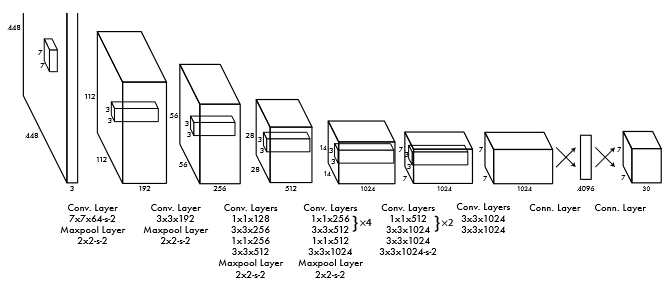

https://arxiv.org/pdf/1506.02640.pdf

The model divides input image into an S × S grid and for each grid cell predicts B bounding boxes (but no more than one class per grid cell), confidence for those boxes, and C class probabilities. These predictions are encoded as an S × S × (C + B ∗ 5) tensor, where 5 is the number of predicted values for each bounding box:
1. confidence
2. x
3. y
4. width
5. height

In [ ]:
I = 448 # image size (IxIx3)
S = 7   # grid size (SxS)
B = 2   # predictions per grid cell
C = 20  # number of classes

In [ ]:
def add_conv_block(model, parameters, pooling):
  for filters, kernel_size, strides in parameters:
    model = layers.Conv2D(filters, kernel_size, strides, padding="same", activation="relu")(model)

  if pooling:
    model = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(model)

  return model

def create_model(augmented=False):
  inputs = keras.Input(shape=(I, I, 3))
  outputs = inputs

  if augmented:
    outputs = layers.RandomBrightness(0.2)(outputs)
    outputs = layers.RandomContrast(0.4)(outputs)
    outputs = augmentation.RandomSaturation(0, 6)(outputs)

  outputs = add_conv_block(outputs, [(64, 7, 2)], True)

  outputs = add_conv_block(outputs, [(192, 3, 1)], True)

  outputs = add_conv_block(outputs, [(128, 1, 1),
                                     (256, 3, 1),
                                     (256, 1, 1),
                                     (512, 3, 1)], True)

  for _ in range(4):
    outputs = add_conv_block(outputs, [(256, 1, 1)], False)
    outputs = add_conv_block(outputs, [(512, 3, 1)], False)
  outputs = add_conv_block(outputs, [(512, 1, 1),
                                     (1024, 3, 1)], True)

  for _ in range(2):
    outputs = add_conv_block(outputs, [(512, 1, 1)], False)
    outputs = add_conv_block(outputs, [(1024, 3, 1)], False)
  outputs = add_conv_block(outputs, [(1024, 3, 1),
                                     (1024, 3, 2)], False)

  for _ in range(2):
    outputs = add_conv_block(outputs, [(1024, 3, 1)], False)

  outputs = layers.Flatten()(outputs)
  outputs = layers.Dense(4096, input_shape=(7, 7, 1024))(outputs)
  outputs = layers.Dropout(0.5)(outputs)
  outputs = layers.Dense(S * S * (C + B * 5))(outputs)
  outputs = layers.Reshape((S, S, C + B * 5))(outputs)

  model = keras.Model(inputs, outputs)

  return model

# Dataset


In [ ]:
def create_dataset(bucket_name, drive, dataframe_csv, batch_size, augmented=False, shuffle=False):
  dataset_name,_ = os.path.splitext(dataframe_csv)
  if augmented:
    dataset_name = dataset_name + '_augmented'
  dataset_name = dataset_name + '.tfrecords'
  dataset_dir = os.path.dirname(dataframe_csv)

  drive.download(dataframe_csv)
  dataframe = pd.read_csv(dataframe_csv, names = ['path','image_file', 'label_file'])

  length = len(dataframe)
  if augmented:
    length *= 3

  storage_client = cloud.storage.Client()
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(dataset_name)
  blob_uri = "gs://" + os.path.join(bucket_name, dataset_name)
  if not blob.exists():
    try:
      with tf.io.TFRecordWriter(blob_uri) as tf_writer:
        for row in dataframe.itertuples():
          path = os.path.join(dataset_dir, row.path)
          image_path = os.path.join(path, row.image_file)
          label_path = os.path.join(path, row.label_file)

          drive.download(image_path)
          image = preprocessing.image.load_img(image_path, target_size=(I,I))
          image = preprocessing.image.img_to_array(image)
          image = tf.constant(image, tf.float32)

          drive.download(label_path)
          labels = []
          with open(label_path) as f:
            for line in f.readlines():
              c, x, y, w, h = [ float(x) for x in line.replace("\n", "").split() ]
              labels.append((c, x, y, w, h))

          tf_writer.write(
              utils.get_example(image, labels, S, B, C).SerializeToString()
          )

          if not augmented:
            continue

          # flip
          flipped_image, flipped_labels = augmentation.h_flip(image, labels)
          tf_writer.write(
              utils.get_example(flipped_image, flipped_labels, S, B, C).SerializeToString()
          )

          # crop
          cropped_image, cropped_labels = augmentation.crop_on_boxes(image, labels, 0.5, 20)
          tf_writer.write(
              utils.get_example(cropped_image, cropped_labels, S, B, C).SerializeToString()
          )
    except Exception:
      blob.delete()
      raise

  dataset = tf.data.TFRecordDataset([blob_uri]).map(
    lambda record : tf.io.parse_single_example(
        record,
        {"image": tf.io.FixedLenFeature([], tf.string),
         "label": tf.io.FixedLenFeature([], tf.string)})
  ).map(
      lambda example : (
        tf.io.parse_tensor(example["image"], tf.float32),
        tf.io.parse_tensor(example["label"], tf.float32))
  ).map(
      lambda x, y : (
        tf.reshape(x, [I, I, 3]),
        tf.reshape(y, [S, S, C + 5]))
  )

  if shuffle:
    dataset = dataset.shuffle(length)

  return dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat(), length

# Loss function

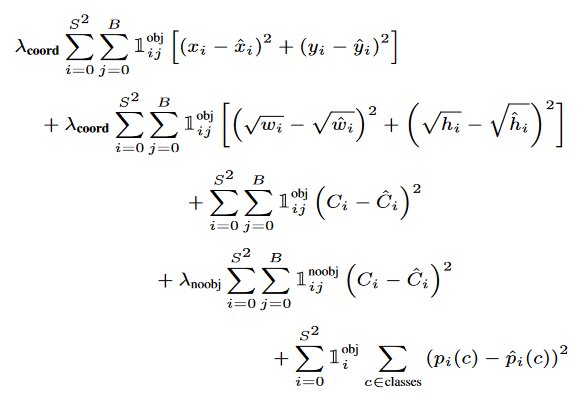

where $\mathbb{1}_i^{obj}$ denotes if object appears in cell *i* and $\mathbb{1}_{ij}^{obj}$ denotes that the *j*$^{th}$ bounding box predictor in cell *i* is “responsible” for that prediction.

In [ ]:
@tf.function()
def yolo_loss(truth, prediction):
  batch_size = tf.shape(truth)[0]
  lambda_coord = 5
  lambda_noobj = 0.5

  b = 0
  ious = tf.TensorArray(tf.float32, size=B)
  for i in tf.range(C+1, C+(B*5), 5):
      box_coord_truth = tf.slice(truth, [0,0,0,C+1], [batch_size,S,S,4])
      box_coord_prediction = tf.slice(prediction, [0,0,0,i], [batch_size,S,S,4])
      iou = math.intersection_over_union(box_coord_truth, box_coord_prediction)
      ious = ious.write(b, iou)
      b += 1
  responsible_box = tf.math.argmax(ious.stack(), output_type=tf.dtypes.int32)

  box_truth = tf.slice(truth, [0,0,0,C+1], [batch_size,S,S,4])
  box_truth_confidence = tf.reshape(
      tf.slice(truth, [0,0,0,C], [batch_size,S,S,1]), [batch_size, S * S, 1])
  box_truth_sqrt_size = tf.reshape(
      tf.math.sqrt(
          tf.slice(box_truth, [0,0,0,2], [batch_size,S,S,2])), [batch_size, S * S, 2])
  box_truth_sqrt_w = tf.reshape(
      tf.slice(box_truth_sqrt_size, [0,0,0], [batch_size, S * S, 1]), [batch_size, S * S, 1]
  )
  box_truth_sqrt_h = tf.reshape(
      tf.slice(box_truth_sqrt_size, [0,0,1], [batch_size, S * S, 1]), [batch_size, S * S, 1]
  )

  b = 0
  box_prediction = tf.zeros([batch_size,S,S,5])
  for i in tf.range(C, C+(B*5), 5):
      tf.autograph.experimental.set_loop_options(
        shape_invariants=[(box_prediction, tf.TensorShape([None,S,S,5]))]
      )
      box = tf.slice(prediction, [0,0,0,i], tf.shape(box_prediction))
      is_responsible = tf.math.equal(responsible_box, b)
      box_prediction = tf.add(box_prediction, tf.where(
          is_responsible, box, tf.zeros(tf.shape(box_prediction))))
      b += 1

  box_prediction_confidence = tf.reshape(
      tf.slice(box_prediction, [0,0,0,0], [batch_size,S,S,1]), [batch_size, S * S, 1])
  box_prediction_size = tf.slice(box_prediction, [0,0,0,3], [batch_size,S,S,2])
  box_prediction_sqrt_size = tf.reshape(
      tf.math.sign(box_prediction_size) * tf.math.sqrt(abs(box_prediction_size)),
      [batch_size, S * S, 2])
  box_prediction_sqrt_w = tf.reshape(
      tf.slice(box_prediction_sqrt_size, [0,0,0], [batch_size, S * S, 1]), [batch_size, S * S, 1]
  )
  box_prediction_sqrt_h = tf.reshape(
      tf.slice(box_prediction_sqrt_size, [0,0,1], [batch_size, S * S, 1]), [batch_size, S * S, 1]
  )
  box_size_losses = box_truth_confidence * ( tf.math.squared_difference(box_truth_sqrt_w, box_prediction_sqrt_w) +
                                             tf.math.squared_difference(box_truth_sqrt_h, box_prediction_sqrt_h) )

  box_truth_position_x = tf.reshape(
      tf.slice(box_truth, [0,0,0,0], [batch_size,S,S,1]), [batch_size, S * S, 1]
  )
  box_truth_position_y = tf.reshape(
      tf.slice(box_truth, [0,0,0,1], [batch_size,S,S,1]), [batch_size, S * S, 1]
  )
  box_prediction_position_x = tf.reshape(
      tf.slice(box_prediction, [0,0,0,1], [batch_size,S,S,1]), [batch_size, S * S, 1]
  )
  box_prediction_position_y = tf.reshape(
      tf.slice(box_prediction, [0,0,0,2], [batch_size,S,S,1]), [batch_size, S * S, 1]
  )

  box_position_losses = box_truth_confidence * ( tf.math.squared_difference(box_truth_position_x, box_prediction_position_x) +
                                                 tf.math.squared_difference(box_truth_position_y, box_prediction_position_y) )

  confidence_sqr = tf.math.square(box_truth_confidence - box_prediction_confidence)
  obj_confidence_losses = box_truth_confidence * confidence_sqr
  noobj_confidence_losses = (1 - box_truth_confidence) * confidence_sqr

  class_truth = tf.slice(truth, [0,0,0,0], [batch_size,S,S,C])
  class_truth = tf.reshape(class_truth, [batch_size, S * S, C])
  class_prediction = tf.slice(prediction, [0,0,0,0], [batch_size,S,S,C])
  class_prediction = tf.reshape(class_prediction, [batch_size, S * S, C])
  class_losses = box_truth_confidence * tf.math.reduce_sum(
      tf.math.squared_difference(class_truth, class_prediction), axis=2, keepdims=True)

  loss = (
      lambda_coord * tf.math.reduce_sum(box_position_losses, axis=1)
      + lambda_coord * tf.math.reduce_sum(box_size_losses, axis=1)
      + tf.math.reduce_sum(obj_confidence_losses, axis=1)
      + lambda_noobj * tf.math.reduce_sum(noobj_confidence_losses, axis=1)
      + tf.math.reduce_sum(class_losses, axis=1))

  return tf.math.reduce_mean(loss)

## Test

In [ ]:
def test_loss():
  # baseline
  truth = np.zeros((1, 7, 7, 25), dtype=np.float32)
  prediction = np.zeros((1, 7, 7, 30), dtype=np.float32)
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 0.0)

  # position error
  truth[0][0][0][C] = 1.0   # confidence
  truth[0][0][0][C+1] = 1.0 # x
  truth[0][0][0][C+2] = 1.0 # y
  prediction[0][0][0][C] = 1.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 10.0)

  # size error
  truth[0][0][0][C+3] = 4.0 # w
  truth[0][0][0][C+4] = 4.0 # h
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 50.0)

  # perfect box prediction
  prediction[0][0][0][C+1] = 1.0
  prediction[0][0][0][C+2] = 1.0
  prediction[0][0][0][C+3] = 4.0
  prediction[0][0][0][C+4] = 4.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 0.0)

  # perfect box prediction in the second cell
  prediction = np.zeros((1, 7, 7, 30), dtype=np.float32)
  prediction[0][0][0][C+5] = 1.0
  prediction[0][0][0][C+6] = 1.0
  prediction[0][0][0][C+7] = 1.0
  prediction[0][0][0][C+8] = 4.0
  prediction[0][0][0][C+9] = 4.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 0.0)

  # confidence error
  prediction[0][0][0][C+5] = 0.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 1.0)

  # class error
  truth[0][0][0][0] = 1.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 2.0)

  # no object error
  truth[0][0][0][C] = 0.0
  prediction[0][0][0][C+5] = 1.0
  loss = yolo_loss(tf.constant(truth), tf.constant(prediction))
  tf.debugging.assert_equal(loss, 0.5)

test_loss()

# Metric function

 - TP - true positive
 - FP - false positive
 - FN - false negative

In [ ]:
@tf.function()
def yolo_mAP(truth, prediction, iou_threshold, confidence_threshold):
  batch_size = tf.shape(truth)[0]

  truth_classes = tf.slice(truth, [0,0,0,0], [batch_size,S,S,C])
  truth_classes = tf.math.argmax(truth_classes, -1)
  truth_classes = tf.expand_dims(truth_classes, -1)
  truth_classes = tf.cast(truth_classes, dtype=tf.float32)
  truth_boxes = tf.slice(truth, [0,0,0,C], [batch_size,S,S,5])
  truth_boxes = tf.concat([truth_classes, truth_boxes], -1)

  prediction_classes = tf.slice(prediction, [0,0,0,0], [batch_size,S,S,C])
  prediction_classes = tf.math.argmax(prediction_classes, -1)
  prediction_classes = tf.expand_dims(prediction_classes, -1)
  prediction_classes = tf.cast(prediction_classes, dtype=tf.float32)
  prediction_boxes = tf.slice(prediction, [0,0,0,C], [batch_size,S,S,B*5])
  prediction_boxes = tf.concat([prediction_classes, prediction_boxes], -1)

  average_precision_per_image = tf.TensorArray(tf.float32, size=batch_size)
  countable_images = 0 # we don't count images without any boxes (labeled or predicted)
  for i in tf.range(batch_size):
    precision_per_class = tf.TensorArray(tf.float32, size=C)
    countable_classes = 0 # we don't count classes without any boxes
    for c in tf.range(C):
      TP = 0 # True Positive
      FP = 0 # False Positive
      FN = 0 # False Negative
      tp_recalls = 0
      for sy1 in tf.range(S):
        for sx1 in tf.range(S):
          if truth_boxes[i][sy1][sx1][1] != 1.0:
            continue
          if int(truth_boxes[i][sy1][sx1][0]) != c:
            continue
          recalled = False
          truth_box = tf.cast([
              (truth_boxes[i][sy1][sx1][2] + float(sx1)) / S, # x
              (truth_boxes[i][sy1][sx1][3] + float(sy1)) / S, # y
              truth_boxes[i][sy1][sx1][4], # width
              truth_boxes[i][sy1][sx1][5]  # height
          ], tf.float32)
          for sy2 in tf.range(S):
            for sx2 in tf.range(S):
              for b in tf.range(B):
                if prediction_boxes[i][sy2][sx2][1+b*5] < confidence_threshold:
                  continue
                if int(prediction_boxes[i][sy2][sx2][0]) != c:
                  continue
                prediction_box = tf.cast([
                    (prediction_boxes[i][sy2][sx2][1+b*5+1] + float(sx2)) / S,
                    (prediction_boxes[i][sy2][sx2][1+b*5+2] + float(sy2)) / S,
                    prediction_boxes[i][sy2][sx2][1+b*5+3],
                    prediction_boxes[i][sy2][sx2][1+b*5+4]
                ], tf.float32)
                iou = math.intersection_over_union(truth_box, prediction_box)
                if iou < iou_threshold:
                  continue
                if not recalled:
                  TP += 1
                  recalled = True # It's supposed we use non-max suppression, so we don't penalty multiple TP recalls
                tp_recalls += 1
          if not recalled:
            FN += 1

      total_predictions = 0
      for sy in tf.range(S):
        for sx in tf.range(S):
          for b in tf.range(B):
            if prediction_boxes[i][sy][sx][1+b*5] < confidence_threshold:
              continue
            if int(prediction_boxes[i][sy][sx][0]) != c:
              continue
            total_predictions += 1
      FP = total_predictions - tp_recalls

      precision = 0.0
      if TP == 0 and FP == 0 and FN == 0:
        precision_per_class = precision_per_class.write(c, precision)
        continue
      if (TP + FP) != 0:
        precision = tf.cast(TP / (TP + FP), tf.float32)
      countable_classes += 1
      precision_per_class = precision_per_class.write(c, precision)

    precision_per_class = precision_per_class.stack()
    average_precision = 0.0
    if countable_classes > 0:
      average_precision = tf.reduce_sum(precision_per_class) / tf.cast(countable_classes, tf.float32)

    average_precision_per_image = average_precision_per_image.write(i, average_precision)
    if countable_classes > 0:
      countable_images += 1

  average_precision_per_image = average_precision_per_image.stack()
  mean_average_precision = 0.0
  if countable_images > 0:
    mean_average_precision = tf.reduce_sum(average_precision_per_image) / tf.cast(countable_images, tf.float32)

  return mean_average_precision

## Test

In [ ]:
def test_mAP():
  # baseline
  truth = np.zeros((1, 7, 7, 25), dtype=np.float32)
  prediction = np.zeros((1, 7, 7, 30), dtype=np.float32)
  mAP_08 = yolo_mAP(tf.constant(truth), tf.constant(prediction), 0.8, 0.5)
  tf.debugging.assert_equal(mAP_08, 0.0)

  # perfect prediction
  truth[0][0][0][5] = 1.0
  truth[0][0][0][C] = 1.0
  truth[0][0][0][C+1] = 0.9
  truth[0][0][0][C+2] = 0.9
  truth[0][0][0][C+3] = 0.1
  truth[0][0][0][C+4] = 0.1
  prediction[0][0][0][5] = 1.0
  prediction[0][0][0][C] = 1.0
  prediction[0][0][0][C+1] = 0.9
  prediction[0][0][0][C+2] = 0.9
  prediction[0][0][0][C+3] = 0.1
  prediction[0][0][0][C+4] = 0.1
  mAP_08 = yolo_mAP(tf.constant(truth), tf.constant(prediction), 0.8, 0.5)
  tf.debugging.assert_equal(mAP_08, 1.0)

  # perfect multiple prediction
  prediction[0][0][0][5] = 1.0
  prediction[0][0][0][C+5] = 1.0
  prediction[0][0][0][C+6] = 0.9
  prediction[0][0][0][C+7] = 0.9
  prediction[0][0][0][C+8] = 0.1
  prediction[0][0][0][C+9] = 0.1
  mAP_08 = yolo_mAP(tf.constant(truth), tf.constant(prediction), 0.8, 0.5)
  tf.debugging.assert_equal(mAP_08, 1.0)

  # 1 TP, 1 FP
  prediction[0][0][1][3] = 1.0
  prediction[0][0][1][C] = 1.0
  prediction[0][0][1][C+1] = 0.9
  prediction[0][0][1][C+2] = 0.9
  prediction[0][0][1][C+3] = 0.1
  prediction[0][0][1][C+4] = 0.1
  mAP_08 = yolo_mAP(tf.constant(truth), tf.constant(prediction), 0.8, 0.5)
  tf.debugging.assert_equal(mAP_08, 0.5)

  # 1 TP, 1 FP, 1 FN
  truth[0][0][2][1] = 1.0
  truth[0][0][2][C] = 1.0
  truth[0][0][2][C+1] = 0.9
  truth[0][0][2][C+2] = 0.9
  truth[0][0][2][C+3] = 0.1
  truth[0][0][2][C+4] = 0.1
  mAP_08 = yolo_mAP(tf.constant(truth), tf.constant(prediction), 0.8, 0.5)
  tf.debugging.Assert(tf.abs(mAP_08 - 0.3) < 0.05, [mAP_08])

test_mAP()

# Learning rate schedule

From the [paper](https://arxiv.org/pdf/1506.02640.pdf):

*\"We train the network for about 135 epochs on the training and validation data sets from PASCAL VOC 2007 and 2012. When testing on 2012 we also include the VOC 2007 test data for training. Throughout training we use a batch size of 64, a momentum of 0.9 and a decay of 0.0005.
Our learning rate schedule is as follows: For the first epochs we slowly raise the learning rate from 10$^{−3}$ to 10$^{−2}$. If we start at a high learning rate our model often diverges due to unstable gradients. We continue training with 10$^{−2}$ for 75 epochs, then 10$^{−3}$ for 30 epochs, and finally 10$^{−4}$ for 30 epochs.\"*

In [ ]:
class YoloLRS(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, steps_per_epoch):
    self.steps_per_epoch = steps_per_epoch

  def __call__(self, step):
    epoch = tf.cast(step / self.steps_per_epoch, tf.float32)

    step_1_length = 5.0
    step_1_substep = (1e-2 - 1e-3) / step_1_length
    step_1 = lambda: 1e-3 + (step_1_substep * epoch)
    step_2 = lambda: tf.constant(1e-2)
    step_3 = lambda: tf.constant(1e-3)
    step_4 = lambda: tf.constant(1e-4)

    return tf.case([(tf.less_equal(epoch, step_1_length), step_1),
                    (tf.less_equal(epoch, 70), step_2),
                    (tf.less_equal(epoch, 100), step_3)], default = step_4)

# Train function

In [ ]:
def train(loss, metrics,
          train_dataframe_path,
          validation_dataframe_path,
          batch_size, epochs,
          log_dir, experiment_name=None,
          checkpoint_dir="Checkpoints/YOLO",
          augmented=True, use_tpu=True, force=False):

  """ Prepare data """

  train_dataset, train_dataset_length = create_dataset(GCS_BUCKET, my_drive, train_dataframe_path, batch_size,
                                                       augmented = augmented, shuffle = True)
  steps_per_epoch = train_dataset_length // batch_size

  validation_dataset, validation_dataset_length = create_dataset(GCS_BUCKET, my_drive, validation_dataframe_path, batch_size)
  validation_steps = validation_dataset_length // batch_size

  """ Prepare environment """

  logs_callback = callbacks.Logger(log_dir, experiment_name)

  # Prepare checkpoint callbacks
  train_dataframe_name = os.path.basename(train_dataframe_path)
  train_dataframe_name,_ = os.path.splitext(train_dataframe_name)
  if augmented:
    train_dataframe_name = train_dataframe_name + '_augmented'
  checkpoint_path = os.path.join(checkpoint_dir, train_dataframe_name)
  checkpoint_name = os.path.join("gs://", GCS_BUCKET, checkpoint_path, '{epoch:03d}')
  checkpoint_options = tf.train.CheckpointOptions(enable_async=True)
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_name,
                                                           save_weights_only=True,
                                                           save_freq=steps_per_epoch*5-1,
                                                           options=checkpoint_options)

  checkpoint_name = os.path.join("gs://", GCS_BUCKET, checkpoint_path, 'yolo_weights_epoch-{epoch:03d}_mAP-{mAP_08:.2f}.hdf5')
  best_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_name,
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                monitor="val_mAP_08",
                                                                mode="max",
                                                                initial_value_threshold=0.5,
                                                                options=checkpoint_options)

  # Find the last available checkpoint or clear all if force=True
  storage_client = cloud.storage.Client()
  bucket = storage_client.bucket(GCS_BUCKET)
  blobs = storage_client.list_blobs(bucket,
                                    prefix=checkpoint_path,
                                    fields='items(name),nextPageToken')
  initial_epoch = 0
  if force:
    for blob in blobs:
      blob = bucket.blob(blob.name)
      blob.delete()
  else:
    for blob in blobs:
      name = os.path.basename(blob.name)
      if not name:
        continue
      name,_ = os.path.splitext(name)
      try:
        name = int(name)
      except:
        continue
      if name > initial_epoch:
        initial_epoch = name  # works as initial epoch, because checkpoint count starts from 1

  # Prepare distribute strategy
  strategy = tf.distribute.get_strategy()
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_NAME, zone=TPU_ZONE)

  if use_tpu:
    while True:
      try:
        tf.config.experimental_connect_to_cluster(resolver)
      except Exception as err:
        if err.args[0].endswith('state: "CREATING"'):
          TIMEOUT = 60
          print(f"TPU Node is in CREATING state. Timeout: {TIMEOUT}s")
          time.sleep(TIMEOUT)
          continue
        raise err
      break
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)

  """ Compile and fit the model """

  with strategy.scope():
    model = create_model()
    if initial_epoch > 0:
      initial_checkpoint = os.path.join("gs://", GCS_BUCKET, checkpoint_path, f'{initial_epoch:03d}')
      model.load_weights(initial_checkpoint)

    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=YoloLRS(steps_per_epoch), momentum=0.9, weight_decay=0.0005),
                  loss = loss, metrics = metrics,
                  steps_per_execution = steps_per_epoch)
  try:
    model.fit(train_dataset,
              verbose = 2,
              validation_data = validation_dataset,
              callbacks = [tf.keras.callbacks.TerminateOnNaN(),
                           logs_callback,
                           checkpoint_callback,
                           best_checkpoint_callback],
              epochs = epochs,
              initial_epoch = initial_epoch,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps)
  finally:
    if use_tpu:
      tf.tpu.experimental.shutdown_tpu_system(resolver)

# Run

## Training

In [ ]:
def run_training(train_dataframe_path,
                 validation_dataframe_path,
                 batch_size, epochs,
                 log_dir, experiment_name=None,
                 augmented=False,
                 use_tpu=False,
                 delete_tpu=False,
                 force=False,
                 attempts=3):
  def mAP_05(truth, prediction):
    return yolo_mAP(truth, prediction, 0.5, 0.5)
  def mAP_08(truth, prediction):
    return yolo_mAP(truth, prediction, 0.8, 0.5)

  if force:
    log_path = log_dir if experiment_name is None else os.path.join(log_dir, experiment_name)
    shutil.rmtree(log_path, ignore_errors=True)
    os.makedirs(log_path, exist_ok = True)
  %tensorboard --logdir=$log_dir

  TIMEOUT = 10
  for i in range(1, attempts+1):
    print(f"Training started. Attempt: {i}")
    try:
      train(yolo_loss, [mAP_05, mAP_08],
            train_dataframe_path = train_dataframe_path,
            validation_dataframe_path = validation_dataframe_path,
            batch_size = batch_size, epochs = epochs,
            log_dir = log_dir,
            experiment_name = experiment_name,
            augmented = augmented,
            use_tpu = use_tpu,
            force = force)
    except:
      traceback.print_exc()
      print("Training failed")
      if i < attempts:
        print(f"Timeout: {TIMEOUT}s")
        time.sleep(TIMEOUT)
      continue
    break

  if use_tpu and delete_tpu:
    time.sleep(180) # Timeout to allow the async checkpoint writer to finish the work
    client = tpu_v1.TpuClient()
    request = tpu_v1.DeleteNodeRequest(
      name=os.path.join('projects', PROJECT_ID,
                        'locations', TPU_ZONE,
                        'nodes', TPU_NAME))
    tpu_v1.GetNodeRequest
    operation = client.delete_node(request=request)
    response = ''
    try:
      response = operation.result()
    except Exception:
      pass
    else:
      print(response)

run_training(train_dataframe_path = "Datasets/YOLO/train.csv",
             validation_dataframe_path = "Datasets/YOLO/test.csv",
             batch_size = 64, epochs = 130,
             log_dir=LOG_DIR, experiment_name="baseline",
             augmented=True,
             use_tpu=True,
             delete_tpu=True,
             force=True)